In [1]:
!pip install -q yfinance pandas scikit-learn matplotlib


In [2]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

In [3]:
TICKERS = ["MSFT", "AAPL", "NVDA", "AMZN", "GOOGL"]
DATA_PATH = "stocks_data.pkl"

if os.path.exists(DATA_PATH):
    stock_hist = pd.read_pickle(DATA_PATH)
else:
    stock_hist = yf.download(TICKERS, period="max")
    stock_hist.to_pickle(DATA_PATH)

print("Downloaded shape:", stock_hist.shape)
print("Column index (first 10):", list(stock_hist.columns[:10]))
stock_hist.head()

Downloaded shape: (11343, 25)
Column index (first 10): [('Close', 'AAPL'), ('Close', 'AMZN'), ('Close', 'GOOGL'), ('Close', 'MSFT'), ('Close', 'NVDA'), ('High', 'AAPL'), ('High', 'AMZN'), ('High', 'GOOGL'), ('High', 'MSFT'), ('High', 'NVDA')]


Price          Close                           High                       ...  \
Ticker          AAPL AMZN GOOGL MSFT NVDA      AAPL AMZN GOOGL MSFT NVDA  ...   
Date                                                                      ...   
1980-12-12  0.098389  NaN   NaN  NaN  NaN  0.098817  NaN   NaN  NaN  NaN  ...   
1980-12-15  0.093256  NaN   NaN  NaN  NaN  0.093684  NaN   NaN  NaN  NaN  ...   
1980-12-16  0.086412  NaN   NaN  NaN  NaN  0.086839  NaN   NaN  NaN  NaN  ...   
1980-12-17  0.088550  NaN   NaN  NaN  NaN  0.088978  NaN   NaN  NaN  NaN  ...   
1980-12-18  0.091118  NaN   NaN  NaN  NaN  0.091545  NaN   NaN  NaN  NaN  ...   

Price           Open                          Volume                       
Ticker          AAPL AMZN GOOGL MSFT NVDA       AAPL AMZN GOOGL MSFT NVDA  
Date                                                                       
1980-12-12  0.098389  NaN   NaN  NaN  NaN  469033600  NaN   NaN  NaN  NaN  
1980-12-15  0.093684  NaN   NaN  NaN  NaN  175884800  NaN   NaN  NaN  NaN  
1980-12-16  0.086839  NaN   NaN  NaN  NaN  105728000  NaN   NaN  NaN  NaN  
1980-12-17  0.088550  NaN   NaN  NaN  NaN   86441600  NaN   NaN  NaN  NaN  
1980-12-18  0.091118  NaN   NaN  NaN  NaN   73449600  NaN   NaN  NaN  NaN  

[5 rows x 25 columns]

<Figure size 1800x800 with 0 Axes>

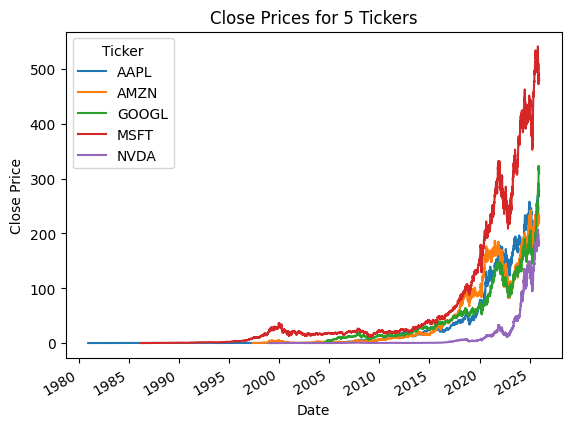

In [4]:
plt.figure(figsize=(18,8))
stock_hist["Close"].plot(title="Close Prices for 5 Tickers")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

In [5]:
actual_close = stock_hist["Close"].copy().rename(columns={c: f"{c}_Actual_Close" for c in stock_hist["Close"].columns})

target = (stock_hist["Close"].shift(-1) > stock_hist["Close"]).astype(int).rename(columns={c: f"{c}_Target" for c in stock_hist["Close"].columns})

stock_prev = stock_hist.shift(1)
predictors_base = ["Close", "Volume", "Open", "High", "Low"]
prev_predictors = stock_prev[predictors_base]

prev_predictors.columns = [f"{col[1]}_{col[0]}" for col in prev_predictors.columns]

dataset = pd.concat([actual_close, target, prev_predictors], axis=1).iloc[1:]  # drop first row with NaNs from shift(1)
print("Dataset columns sample:", dataset.columns[:20].tolist())


Dataset columns sample: ['AAPL_Actual_Close', 'AMZN_Actual_Close', 'GOOGL_Actual_Close', 'MSFT_Actual_Close', 'NVDA_Actual_Close', 'AAPL_Target', 'AMZN_Target', 'GOOGL_Target', 'MSFT_Target', 'NVDA_Target', 'AAPL_Close', 'AMZN_Close', 'GOOGL_Close', 'MSFT_Close', 'NVDA_Close', 'AAPL_Volume', 'AMZN_Volume', 'GOOGL_Volume', 'MSFT_Volume', 'NVDA_Volume']


In [6]:
df = dataset.copy()

weekly = stock_hist["Close"].rolling(7).mean()
quarterly = stock_hist["Close"].rolling(90).mean()
annual = stock_hist["Close"].rolling(365).mean()

for t in TICKERS:
    df[f"{t}_weekly_mean"] = (weekly[t] / stock_hist["Close"][t]).rename(f"{t}_weekly_mean")
    df[f"{t}_quarterly_mean"] = (quarterly[t] / stock_hist["Close"][t]).rename(f"{t}_quarterly_mean")
    df[f"{t}_annual_mean"] = (annual[t] / stock_hist["Close"][t]).rename(f"{t}_annual_mean")

    df[f"{t}_annual_weekly_ratio"] = (df[f"{t}_annual_mean"] / df[f"{t}_weekly_mean"]).rename(f"{t}_annual_weekly_ratio")
    df[f"{t}_annual_quarterly_ratio"] = (df[f"{t}_annual_mean"] / df[f"{t}_quarterly_mean"]).rename(f"{t}_annual_quarterly_ratio")

    df[f"{t}_open_close_ratio"] = (stock_hist["Open"][t] / stock_hist["Close"][t]).rename(f"{t}_open_close_ratio")
    df[f"{t}_high_close_ratio"] = (stock_hist["High"][t] / stock_hist["Close"][t]).rename(f"{t}_high_close_ratio")
    df[f"{t}_low_close_ratio"] = (stock_hist["Low"][t] / stock_hist["Close"][t]).rename(f"{t}_low_close_ratio")

df = df.dropna().copy()
print("After feature creation, rows:", df.shape[0])


After feature creation, rows: 5000


In [7]:
predictor_columns = [c for c in df.columns if any(c.endswith(suffix) for suffix in ["_Close","_Volume","_Open","_High","_Low"])]

extra_features = [c for c in df.columns if any(k in c for k in [
    "_weekly_mean","_quarterly_mean","_annual_mean",
    "_annual_weekly_ratio","_annual_quarterly_ratio",
    "_open_close_ratio","_high_close_ratio","_low_close_ratio"
])]

full_predictors = sorted(list(set(predictor_columns + extra_features)))
print("Num predictors:", len(full_predictors))
print("Example predictors:", full_predictors[:12])


Num predictors: 70
Example predictors: ['AAPL_Actual_Close', 'AAPL_Close', 'AAPL_High', 'AAPL_Low', 'AAPL_Open', 'AAPL_Volume', 'AAPL_annual_mean', 'AAPL_annual_quarterly_ratio', 'AAPL_annual_weekly_ratio', 'AAPL_high_close_ratio', 'AAPL_low_close_ratio', 'AAPL_open_close_ratio']


In [8]:
def backtest(data, model, predictors, tickers, start=1000, step=750, prob_threshold=0.6):
    n = data.shape[0]
    if start >= n:
        start = max(365, int(n * 0.5))
        start = min(start, n-2)
    all_predictions = []

    for i in range(start, n, step):
        train = data.iloc[:i]
        test = data.iloc[i:i+step]

        for t in tickers:
            target_col = f"{t}_Target"

            if target_col not in train.columns or target_col not in test.columns:
                continue

            y_train = train[target_col].dropna()
            unique_classes = y_train.unique()
            if len(unique_classes) == 0:
                continue

            if len(unique_classes) == 1:
                only_class = unique_classes[0]
                preds = np.full(shape=(len(test),), fill_value=only_class, dtype=int)
            else:
                model.fit(train[predictors], train[target_col])
                proba = model.predict_proba(test[predictors])
                if proba.shape[1] == 1:
                    only_class = model.classes_[0]
                    preds = np.full(shape=(len(test),), fill_value=only_class, dtype=int)
                else:
                    preds = (proba[:,1] > prob_threshold).astype(int)

            combined = pd.DataFrame({
                "Target": test[target_col].values,
                "Pred": preds
            }, index=test.index)
            combined["Ticker"] = t
            all_predictions.append(combined)

    if len(all_predictions) == 0:
        return pd.DataFrame(columns=["Target","Pred","Ticker"])
    return pd.concat(all_predictions)


Predictions rows: 20000

Precision per ticker:
 Ticker
AAPL     0.551948
AMZN     0.594937
GOOGL    0.493506
MSFT     0.506122
NVDA     0.541176
dtype: float64

Overall precision: 0.53125


/tmp/ipython-input-3942760357.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_ticker_precision = pred_final.groupby("Ticker").apply(lambda x: precision_score(x["Target"], x["Pred"]))


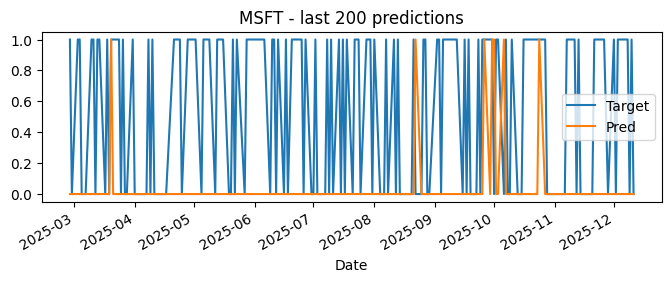

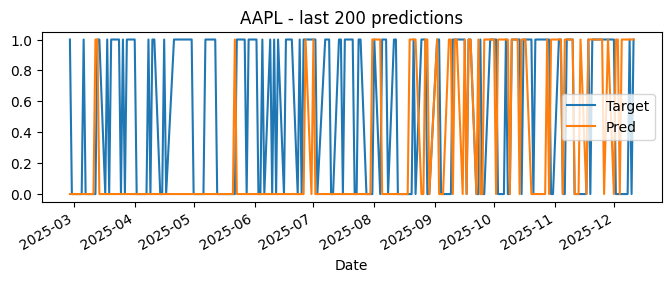

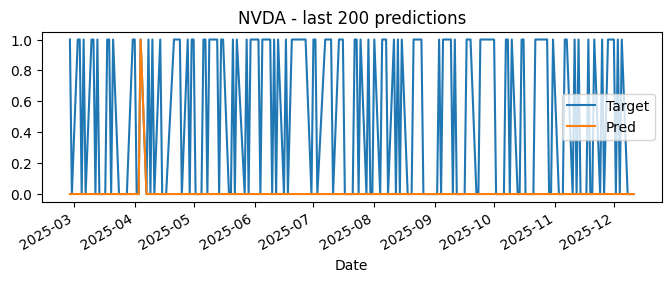

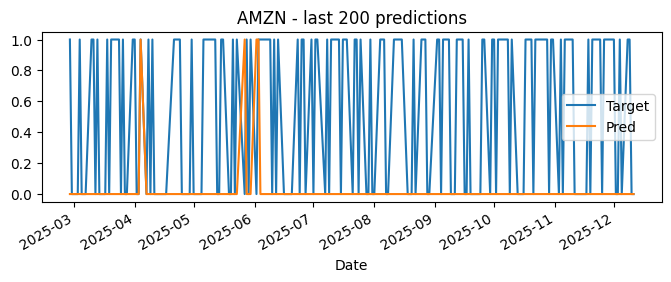

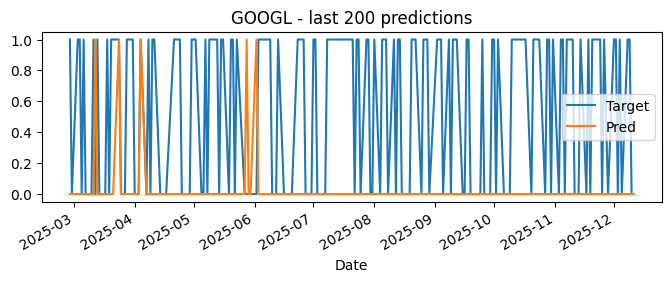

In [9]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

pred_final = backtest(df, model, full_predictors, TICKERS, start=1000, step=750, prob_threshold=0.6)
print("Predictions rows:", pred_final.shape[0])

if pred_final.shape[0] == 0:
    print("No predictions were generated. Try lowering 'start' or check your data length.")
else:
    per_ticker_precision = pred_final.groupby("Ticker").apply(lambda x: precision_score(x["Target"], x["Pred"]))
    print("\nPrecision per ticker:\n", per_ticker_precision)
    print("\nOverall precision:", precision_score(pred_final["Target"], pred_final["Pred"]))

    for t in TICKERS:
        sub = pred_final[pred_final["Ticker"] == t].iloc[-200:]
        if sub.shape[0] > 0:
            ax = sub[["Target","Pred"]].plot(title=f"{t} - last {sub.shape[0]} predictions", figsize=(8,2.5))
            plt.show()
